# Database

In this file the dataset is created in which the graph data will be stored. First part is to read the *.dem* files of the matches played on inferno, than convert the datas into ***HeteroData*** structure so that it can be stored in a PyG database.

In [1]:
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.data import Dataset, Data

import matplotlib.pyplot as plt
from math import floor, ceil
import seaborn as sns
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', 1300)
pd.set_option('display.max_rows', 100)

In [2]:
PATH_GRAPH_NODES = '../../data/inferno_graph/graph_models/manual/nodes_v1_5.csv'
PATH_GRAPH_EDGES = '../../data/inferno_graph/graph_models/manual/edges_v1_5.csv'

PATH_PARSED_DEMOS_2023 = '../../data/demo-parsed/2023'
PATH_PARSED_DEMOS_2022 = '../../data/demo-parsed/2022'

PATH_PLAYER_STATS = '../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv'
#PATH_PLAYER_STATS_INFERNO = '../../data/player-stats/scraped-in-2024/norm_imputed_player_stats_2022.csv'

## Creating HeteroData objects from game snapshots

Collecting the list of the inferno matches.

In [3]:
def get_inferno_matches(folder_path):
    matches = []
    for filename in os.listdir(folder_path + '/frames/'):
        if 'inferno' in filename:
            matches.append(filename)
    return matches

Reading *playerFrame*, *kills* and *rounds* dataframes.

In [4]:
def get_needed_dataframes(folder_path, filename):
    playerFrames = pd.read_csv(folder_path + '/playerFrames/' + filename)
    kills = pd.read_csv(folder_path +'/kills/' + filename)
    rounds = pd.read_csv(folder_path +'/rounds/' + filename)
    bombEvents = pd.read_csv(folder_path + '/bombEvents/' + filename)
    damages = pd.read_csv(folder_path + '/damages/' + filename)


    rounds = rounds[['roundNum', 'tScore', "ctScore" ,'endTScore', 'endCTScore']]
    pf = playerFrames[['tick', 'roundNum', 'seconds', 'side', 'name', 'x', 'y', 'z','eyeX', 'eyeY', 'eyeZ', 'velocityX', 'velocityY', 'velocityZ',
        'hp', 'armor', 'activeWeapon','flashGrenades', 'smokeGrenades', 'heGrenades', 'totalUtility', 'isAlive', 'isReloading', 'isBlinded', 'isDucking',
        'isDefusing', 'isPlanting', 'isUnknown', 'isScoped', 'equipmentValue', 'equipmentValueRoundStart', 'hasHelmet','hasDefuse', 'hasBomb']]
    
    return pf, kills, rounds, bombEvents, damages

Formatting the dataframes: Calculate features, in-game live stats, etc.

In [5]:
def calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages):
    
    # Merge playerFrames with rounds
    pf = pf.merge(rounds, on='roundNum')

    # Kill stats
    pf['stat_kills'] = 0
    pf['stat_HSK'] = 0
    pf['stat_openKills'] = 0
    pf['stat_tradeKills'] = 0

    # Death stats
    pf['stat_deaths'] = 0
    pf['stat_openDeaths'] = 0

    # Assist stats
    pf['stat_assists'] = 0
    pf['stat_flashAssists'] = 0

    # Damage stats
    pf['stat_damage'] = 0
    pf['stat_weaponDamage'] = 0
    pf['stat_nadeDamage'] = 0
    
    # Setting kill-stats
    for index, row in kills.iterrows():

        # Kills
        pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_kills'] += 1

        # HS-kills
        if row['isHeadshot']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_HSK'] += 1

        # Opening-kills
        if row['isFirstKill']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_openKills'] += 1

        # Trading-kills
        if row['isTrade']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_tradeKills'] += 1

        # Deaths
        pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'stat_deaths'] += 1

        # Opening deaths
        if row['isFirstKill']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'stat_openDeaths'] += 1
            
        # Assists
        if pd.notna(row['assisterName']):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['assisterName']), 'stat_assists'] += 1

        # Flash assists
        if row['victimBlinded'] and row['flashThrowerTeam'] != row['victimTeam']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['flashThrowerTeam']), 'stat_flashAssists'] += 1

    # Setting damage-stats
    for index, row in damages.iterrows():

        # All Damage
        if (row['isFriendlyFire'] == False):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_damage'] += row['hpDamageTaken']

        # Weapon Damage
        if (row['isFriendlyFire'] == False) and (row['weaponClass'] != "Grenade" and row['weaponClass'] != "Equipment"):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_weaponDamage'] += row['hpDamageTaken']
        
        # Nade Damage
        if (row['isFriendlyFire'] == False) and (row['weaponClass'] == "Grenade"):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_nadeDamage'] += row['hpDamageTaken']
        
    # Rounded-down seconds
    pf['sec'] = pf['seconds'].apply(lambda x: floor(x))
        
    return pf, kills, rounds

Get the dummie columns for active weapons.

In [6]:
def get_activeWeapon_dummies(pf):
    
    # Active weapons
    active_weapons = [
        # Other
        'activeWeapon_C4', 'activeWeapon_Knife', 'activeWeapon_Taser',
        # Pistols
        'activeWeapon_USP-S', 'activeWeapon_P2000', 'activeWeapon_Glock-18', 'activeWeapon_Dual Berettas', 'activeWeapon_P250', 'activeWeapon_Tec-9', 'activeWeapon_CZ75 Auto', 'activeWeapon_Five-SeveN', 'activeWeapon_Desert Eagle',
        # SMGs
        'activeWeapon_MAC-10', 'activeWeapon_MP9', 'activeWeapon_MP7', 'activeWeapon_MP5-SD', 'activeWeapon_UMP-45', 'activeWeapon_PP-Bizon', 'activeWeapon_P90',
        # Heavy
        'activeWeapon_Nova', 'activeWeapon_XM1014', 'activeWeapon_Sawed-Off', 'activeWeapon_MAG-7', 'activeWeapon_M249', 'activeWeapon_Negev',
        # Rifles
        'activeWeapon_FAMAS', 'activeWeapon_Galil AR', 'activeWeapon_AK-47', 'activeWeapon_M4A4', 'activeWeapon_M4A1', 'activeWeapon_SG 553', 'activeWeapon_AUG', 'activeWeapon_SSG 08', 'activeWeapon_AWP', 'activeWeapon_G3SG1', 'activeWeapon_SCAR-20',
        # Grenades
        'activeWeapon_HE Grenade', 'activeWeapon_Flashbang', 'activeWeapon_Smoke Grenade', 'activeWeapon_Incendiary Grenade', 'activeWeapon_Molotov', 'activeWeapon_Decoy Grenade'
    ]

    # Create dummie cols
    df_dummies = pd.get_dummies(pf['activeWeapon'], prefix="activeWeapon",drop_first=False)
    dummies = pd.DataFrame()
    for col in active_weapons:
        if col not in df_dummies.columns:
            dummies[col] = np.zeros(len(df_dummies))
        else:
            dummies[col] = df_dummies[col]
    
    dummies = dummies*1
    pf = pf.merge(dummies, left_index = True, right_index = True, how = 'left')
    
    return pf

Create a player object to store player related data.

Important setting in the flow: how many snapshots per second.

In [25]:
def player_object_create(pf):
    
    startAsCTPlayerNames = pf[(pf['side'] == 'CT') & (pf['roundNum'] == 1)]['name'].unique()
    startAsTPlayerNames = pf[(pf['side'] == 'T') & (pf['roundNum'] == 1)]['name'].unique()
    players = {}

    # Team 1: start on CT side
    players[0] = pf[pf['name'] == startAsCTPlayerNames[0]].iloc[::8].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[1] = pf[pf['name'] == startAsCTPlayerNames[1]].iloc[::8].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[2] = pf[pf['name'] == startAsCTPlayerNames[2]].iloc[::8].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[3] = pf[pf['name'] == startAsCTPlayerNames[3]].iloc[::8].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[4] = pf[pf['name'] == startAsCTPlayerNames[4]].iloc[::8].copy()   # .drop_duplicates(subset=['sec','roundNum'])

    # Team 2: start on T side
    players[5] = pf[pf['name'] == startAsTPlayerNames[0]].iloc[::8].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[6] = pf[pf['name'] == startAsTPlayerNames[1]].iloc[::8].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[7] = pf[pf['name'] == startAsTPlayerNames[2]].iloc[::8].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[8] = pf[pf['name'] == startAsTPlayerNames[3]].iloc[::8].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[9] = pf[pf['name'] == startAsTPlayerNames[4]].iloc[::8].copy()   # drop_duplicates(subset=['sec','roundNum']).
    
    return players


Find closest and n-closest map node neighbors of a player node. 

In [8]:
# Calculate closest map-graph node
def find_closest(row):
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    return nodes.loc[distances.idxmin(), 'nodeId']

def find_n_closest(row, n=3):
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    closest_indices = distances.argsort()[:n]
    return nodes.loc[closest_indices, 'nodeId'].tolist()

def player_object_calculate_closest_mapnode_feature(players):

    for idx, player in enumerate(players):
        
        players[idx] = players[idx].replace(True, 1)
        players[idx] = players[idx].replace(False, 0)
        players[idx]['isCT'] = players[idx]['side'].apply(lambda x: 1 if x == 'CT' else 0)
        players[idx]['closestId'] = players[idx].apply(find_closest, axis=1)

        del players[idx]['side']            # Deleted because isCT flag holds the info
        del players[idx]['activeWeapon']    # Deleted because of the activeWeapon_*weapon* dummie columns
    
    return players

Get the player edges.

In [9]:
def create_playerEdges_dataframe(players):
    
    playerEdges = None

    for idx in range(0,len(players)):
        temp = players[idx][['roundNum','sec','closestId']].copy()
        temp['playerId'] = idx
        if playerEdges is None:
            playerEdges = temp
        else:
            playerEdges = pd.concat([playerEdges, temp])
    
    return playerEdges

Calculate graph level features like time, players alive, etc.

In [10]:
def calculate_ct_equipment_value(row):
    if row['player0_isCT']:
        return row[['player0_equi_val_alive', 'player1_equi_val_alive', 'player2_equi_val_alive', 'player3_equi_val_alive', 'player4_equi_val_alive']].sum()
    else:
        return row[['player5_equi_val_alive', 'player6_equi_val_alive', 'player7_equi_val_alive', 'player8_equi_val_alive', 'player9_equi_val_alive']].sum()

def calculate_t_equipment_value(row):
    if row['player0_isCT'] == False:
        return row[['player0_equi_val_alive', 'player1_equi_val_alive', 'player2_equi_val_alive', 'player3_equi_val_alive', 'player4_equi_val_alive']].sum()
    else:
        return row[['player5_equi_val_alive', 'player6_equi_val_alive', 'player7_equi_val_alive', 'player8_equi_val_alive', 'player9_equi_val_alive']].sum()



def get_graph_level_data(players, rounds):
    # Copy players object
    graph_players = {}
    for idx in range(0,len(players)):
        graph_players[idx] = players[idx].copy()

    colsNotToRename = ['tick', 'roundNum', 'seconds', 'sec']

    # Rename columns except for tick, roundNum, seconds, floorSec
    for idx in range(0,len(graph_players)):
        
        for col in graph_players[idx].columns:
            if col not in colsNotToRename:
                graph_players[idx].rename(columns={col: "player" + str(idx) + "_" + col}, inplace=True)

    # Create a graph dataframe to store all players in 1 row per second
    graph_data = graph_players[0].copy()

    # Merge dataframes
    for i in range(1, len(graph_players)):
        graph_data = graph_data.merge(graph_players[i], on=colsNotToRename)
        
    graph_data = graph_data.merge(rounds, on=['roundNum'])
    graph_data['CT_winsRound'] = graph_data.apply(lambda x: 1 if (x['endCTScore'] > x['ctScore']) else 0, axis=1)
    graph_data['CT_aliveNum'] = graph_data[['player0_isAlive','player1_isAlive','player2_isAlive','player3_isAlive','player4_isAlive']].sum(axis=1)
    graph_data['T_aliveNum'] = graph_data[['player5_isAlive','player6_isAlive','player7_isAlive','player8_isAlive','player9_isAlive']].sum(axis=1)
    graph_data['player0_equi_val_alive'] = graph_data['player0_equipmentValue'] * graph_data['player0_isAlive']
    graph_data['player1_equi_val_alive'] = graph_data['player1_equipmentValue'] * graph_data['player1_isAlive']
    graph_data['player2_equi_val_alive'] = graph_data['player2_equipmentValue'] * graph_data['player2_isAlive']
    graph_data['player3_equi_val_alive'] = graph_data['player3_equipmentValue'] * graph_data['player3_isAlive']
    graph_data['player4_equi_val_alive'] = graph_data['player4_equipmentValue'] * graph_data['player4_isAlive']
    graph_data['player5_equi_val_alive'] = graph_data['player5_equipmentValue'] * graph_data['player5_isAlive']
    graph_data['player6_equi_val_alive'] = graph_data['player6_equipmentValue'] * graph_data['player6_isAlive']
    graph_data['player7_equi_val_alive'] = graph_data['player7_equipmentValue'] * graph_data['player7_isAlive']
    graph_data['player8_equi_val_alive'] = graph_data['player8_equipmentValue'] * graph_data['player8_isAlive']
    graph_data['player9_equi_val_alive'] = graph_data['player9_equipmentValue'] * graph_data['player9_isAlive']
    graph_data['CT_equipmentValue'] = graph_data.apply(calculate_ct_equipment_value, axis=1)
    graph_data['T_equipmentValue'] = graph_data.apply(calculate_t_equipment_value, axis=1)
    del graph_data['player0_equi_val_alive']
    del graph_data['player1_equi_val_alive']
    del graph_data['player2_equi_val_alive']
    del graph_data['player3_equi_val_alive']
    del graph_data['player4_equi_val_alive']
    del graph_data['player5_equi_val_alive']
    del graph_data['player6_equi_val_alive']
    del graph_data['player7_equi_val_alive']
    del graph_data['player8_equi_val_alive']
    del graph_data['player9_equi_val_alive']
    
    return graph_data

Read inferno graph model.

In [11]:
def get_inferno_graph_nodes_and_edges():
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    edges = pd.read_csv(PATH_GRAPH_EDGES)
    
    nodes['x'] = nodes['x'].astype('float32')
    nodes['y'] = nodes['y'].astype('float32')
    nodes['isPath'] = nodes['type'].apply(lambda x: 1 if x == 'path' else 0)
    
    return nodes, edges

Get box-score statistics for the players.

TODO: Solve NaN problem

In [12]:
def get_player_overall_statistics_without_inferno(players):
    # Needed columns
    needed_stats = ['player_name', 'rating_2.0', 'DPR', 'KAST', 'Impact', 'ADR', 'KPR','total_kills', 'HS%', 'total_deaths', 'KD_ratio', 'dmgPR',
       'grenade_dmgPR', 'maps_played', 'saved_by_teammatePR', 'saved_teammatesPR','opening_kill_rating', 'team_W%_after_opening',
       'opening_kill_in_W_rounds', 'rating_1.0_all_Career', 'clutches_won_1on1', 'clutches_won_1on2', 'clutches_won_1on3', 'clutches_won_1on4', 'clutches_won_1on5']
    
    stats = pd.read_csv(PATH_PLAYER_STATS)
    stats['player_name'] = stats['player_name'].apply(lambda x: x.replace('-', '') if '-' in x else x)
    stats['player_name'] = stats['player_name'].apply(lambda x: x.replace(' ', '') if '-' in x else x)
    stats = stats[needed_stats]
    stats['rating_1.0_all_Career'] = stats['rating_1.0_all_Career'].astype('float32')

    for col in stats.columns:
        if col != 'player_name':
            stats[col] = stats[col].astype('float32')
            stats.rename(columns={col: "overall_" + col}, inplace=True)
    
    for idx in range(0,len(players)):
        players[idx] = pd.merge(players[idx], stats, left_on='name', right_on='player_name', how='left').drop(columns=['player_name'])
        
    return players

Format player data for HeteroData object creation.

In [13]:
def create_playerFrameData_for_graph(players, roundNum, sec):
    playerFrameData = pd.DataFrame(columns=players[0].columns)
    for idx in range(0,len(players)):
        playerFrameData.loc[idx] = players[idx].loc[(players[idx]['roundNum'] == roundNum) & (players[idx]['sec'] == sec)].iloc[0]
        
    playerFrameData.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)
    playerFrameData = playerFrameData.astype('float32')
    
    return playerFrameData

Create the HeteroData object.

In [14]:
def create_HeteroData(playerFrameData, playerEdges, graph_data, nodes, edges, roundNum, sec):
    data = HeteroData()

    # Create a sample heterogeneous graph with node, edge, and multiple graph-level features
    data['player'].x = torch.tensor(playerFrameData.astype('float32').values)
    data['map'].x = torch.tensor(nodes[['x','y','isPath']].astype('float32').values)

    data['map', 'connected_to', 'map'].edge_index = torch.tensor(edges.T.values)
    data['player', 'closest_to', 'map'].edge_index = torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == roundNum) & (playerEdges['sec'] == sec)][['playerId','closestId']].T.values)


    # Define multiple graph-level features
    data.y = {
        'roundNum': roundNum.astype('float32'),
        'sec': sec.astype('float32'),
        'team1AliveNum': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['team1AliveNum'].iloc[0].astype('float32')),
        'team2AliveNum': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['team2AliveNum'].iloc[0].astype('float32')),
        'CTwinsRound': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['CTwinsRound'].iloc[0])
    }
    
    return data

----------
## Dataset for HeteroData objects

In [15]:
class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


#### Codes testing the created dataset class

In [15]:
# infdataset = InfernoDataset([data])
# torch.save(infdataset, './data/_/test_dataset.pt')
# dataset = torch.load('./data/_/test_dataset.pt')
# loader = DataLoader(infdataset, batch_size=1, shuffle=True)

---------
## Creating the dataset

In [15]:
# Consts
FOLDER_READ_PATH = '../data/demo-parsed/2023'
FOLDER_SAVE_PATH = './graph-dataset/inferno_graph_dataset.pt'
LAST_SAVED_TXT_PATH = './graph-dataset/last-saved.txt'

# Params for workflow
hetero_data_list = []
reached_last_save = False
last_saved = ''

# Get matches
matches = get_inferno_matches(FOLDER_READ_PATH)

# Get last saved demo
try:
    with open(LAST_SAVED_TXT_PATH, 'r') as file:
        last_saved = file.read()
except:
    last_saved = ''

# Start the creation of graphs
for idx,match in enumerate(matches):

    # Skip the matches with damaged data structure
    if match == 'blast-premier-spring-final-2023-g2-vs-cloud9-bo3-l6_WROLL2MODdQ0NexGWUJg2-vs-cloud9-m2-inferno.dem.csv'  or \
       match == 'iem-cologne-2023-g2-vs-faze-bo3-2rs0vwSX-MC7GnSL4ITW06g2-vs-faze-m1-inferno.dem.csv' or \
       match == 'iem-cologne-2023-g2-vs-astralis-bo3-_w4eg3Jhwy1dhctFRgGSl7g2-vs-astralis-m2-inferno.dem.csv' or \
       match == 'iem-katowice-2023-faze-vs-ihc-bo3-xzdrX8BWDhgJKqFJblorpafaze-vs-ihc-m1-inferno.dem.csv':
        continue
    
    # Skip already processed demos
    if last_saved == '':
        reached_last_save = True
    elif last_saved != match and reached_last_save == False:
        continue
    elif last_saved == match and reached_last_save == False:
        reached_last_save = True
        continue
    
    # Create graph
    pf, kills, rounds, bombEvents, damages = get_needed_dataframes(FOLDER_READ_PATH, match)
    pf, kills, rounds = calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages)
    pf = get_activeWeapon_dummies(pf)
    players = player_object_create(pf)
    players = player_object_calculate_closest_mapnode_feature(players)
    players = get_player_overall_statistics_without_inferno(players)
    player_edges = create_playerEdges_dataframe(players)
    graph_data = get_graph_level_data(players, rounds)
    nodes, edges = get_inferno_graph_nodes_and_edges()

    rounds_list = pf['roundNum'].unique()
    for roundNum in rounds_list:
        sec_list = pf[pf['roundNum'] == roundNum]['sec'].unique()
        for sec in sec_list:
            playerFrameData = create_playerFrameData_for_graph(players, roundNum, sec)
            data = create_HeteroData(playerFrameData, player_edges, graph_data, nodes, edges, roundNum, sec)
            hetero_data_list.append(data)
        print(match,roundNum)
    
    if idx % 5 == 0:
        if os.path.exists('./data/inferno_graph_dataset_3.pt') == False:
            infdataset = InfernoDataset(hetero_data_list)
            torch.save(infdataset, './data/inferno_graph_dataset_3.pt')
            hetero_data_list = []
        elif os.path.exists('./data/inferno_graph_dataset_3.pt') == True:
            infdataset = torch.load('./data/inferno_graph_dataset_3.pt')
            infdataset.data_list = infdataset.data_list + hetero_data_list
            torch.save(infdataset, './data/inferno_graph_dataset_3.pt')
            hetero_data_list = []
        
        with open('last-saved.txt', 'w') as file:
            file.write(match)

iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 1
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 2
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 3
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 4
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 5
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 6
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 7
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 8
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 9
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 10
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og-m2-inferno.dem.csv 11
iem-dallas-2023-mouz-vs-og-bo3-tGd7zF8hss-uT_IOarRz-8mouz-vs-og

----------
# Playground

### 1. Workflow test

In [26]:
FOLDER_PATH = '../../data/demo-parsed/2023'
match = 'blast-premier-fall-groups-2023-evil-geniuses-vs-g2-bo3-skJ60UDCIzjbZIG70cNfnjevil-geniuses-vs-g2-m1-inferno.dem.csv'

hetero_data_list = []

pf, kills, rounds, bombEvents, damages = get_needed_dataframes(FOLDER_PATH, match)
pf, kills, rounds = calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages)
pf = get_activeWeapon_dummies(pf)
players = player_object_create(pf)
players = player_object_calculate_closest_mapnode_feature(players)
#players = get_player_overall_statistics_without_inferno(players)
player_edges = create_playerEdges_dataframe(players)
graph_data = get_graph_level_data(players, rounds)
graph_data

tick  roundNum    seconds player0_name    player0_x    player0_y  \
0      19171         1   0.062500       huNter  2469.392334  2092.477539   
1      19299         1   1.062500       huNter  2400.432373  1908.588623   
2      19427         1   2.062500       huNter  2343.622559  1726.379761   
3      19555         1   3.062500       huNter  2395.398193  1515.852661   
4      19683         1   4.062500       huNter  2549.255127  1358.980469   
...      ...       ...        ...          ...          ...          ...   
2208  396285        23  22.351562       huNter   607.360352  2971.736084   
2209  396413        23  23.351562       huNter   601.905701  2964.585693   
2210  396541        23  24.351562       huNter   615.066345  2911.012451   
2211  396669        23  25.351562       huNter   619.603271  2793.788330   
2212  396797        23  26.351562       huNter   619.603699  2799.644287   

       player0_z  player0_eyeX  player0_eyeY  player0_eyeZ  player0_velocityX  \
0     132.031250   2469.392334   2092.477539    196.093811         -12.203775   
1     128.031250   2400.432373   1908.588623    192.093811         -16.701572   
2     147.784485   2343.622559   1726.379761    211.847046          36.817196   
3     160.031250   2395.398193   1515.852661    224.093811         212.745651   
4     160.031250   2549.255127   1358.980469    224.093811          22.239166   
...          ...           ...           ...           ...                ...   
2208  203.170258    607.360352   2971.736084    267.232819         -48.608982   
2209  203.170258    601.905701   2964.585693    267.232819         -99.450951   
2210  203.170258    615.066345   2911.012451    267.232819          73.221413   
2211  193.031250    619.603271   2793.788330    253.840633          -0.916780   
2212  193.031250    619.603699   2799.644287    251.338192           0.433828   

      player0_velocityY  player0_velocityZ  player0_hp  player0_armor  \
0            -54.341820                0.0         100            100   
1           -176.600052                0.0         100            100   
2           -236.856827                0.0         100            100   
3            -70.097260                0.0         100            100   
4           -237.369156                0.0         100            100   
...                 ...                ...         ...            ...   
2208          31.790304                0.0          77             91   
2209        -122.600395                0.0          77             91   
2210        -167.508774                0.0          77             91   
2211          66.962059                0.0          77             91   
2212           6.422563                0.0          77             91   

      player0_flashGrenades  player0_smokeGrenades  player0_heGrenades  \
0                         0                      0                   0   
1                         0                      0                   0   
2                         0                      0                   0   
3                         0                      0                   0   
4                         0                      0                   0   
...                     ...                    ...                 ...   
2208                      0                      0                   0   
2209                      0                      0                   0   
2210                      0                      0                   0   
2211                      0                      0                   0   
2212                      0                      0                   0   

      player0_totalUtility  player0_isAlive  player0_isReloading  \
0                        0                1                    0   
1                        0                1                    0   
2                        0                1                    0   
3                        0                1                    0   
4               

In [27]:
graph_data.loc[graph_data['roundNum'] == 11]

tick  roundNum  seconds player0_name    player0_x    player0_y  \
914   170652        11   0.8750       huNter  2358.193604  2002.512695   
915   170780        11   1.8750       huNter  2178.372314  1854.217773   
916   170908        11   2.8750       huNter  1951.119385  1774.935913   
917   171036        11   3.8750       huNter  1846.386475  1566.217773   
918   171164        11   4.8750       huNter  1826.683960  1320.129883   
...      ...       ...      ...          ...          ...          ...   
1045  187431        11  23.5625       huNter     7.219240  2594.844238   
1046  187559        11  24.5625       huNter     7.219240  2594.844238   
1047  187687        11  25.5625       huNter     7.219240  2594.844238   
1048  187815        11  26.5625       huNter     7.219240  2594.844238   
1049  187943        11  27.5625       huNter     7.219240  2594.844238   

      player0_z  player0_eyeX  player0_eyeY  player0_eyeZ  player0_velocityX  \
914   128.03125   2358.193604   2002.512695    192.093811         -97.799454   
915   128.03125   2178.372314   1854.217773    192.093811        -240.944382   
916   160.03125   1951.119385   1774.935913    224.093811        -194.763138   
917   160.03125   1846.386475   1566.217773    224.093811         -10.068230   
918   160.03125   1826.683960   1320.129883    224.093811         -64.250702   
...         ...           ...           ...           ...                ...   
1045  160.03125    626.417725   2538.606445    289.044935         129.042953   
1046  160.03125    239.110397   2958.312988    174.044935           0.000000   
1047  160.03125    239.110397   2958.312988    174.044935           0.000000   
1048  160.03125    239.110397   2958.312988    174.044935           0.000000   
1049  160.03125    239.110397   2958.312988    174.044935           0.000000   

      player0_velocityY  player0_velocityZ  player0_hp  player0_armor  \
914         -230.076660                0.0         100            100   
915          -49.519287                0.0         100            100   
916         -145.479309                0.0         100            100   
917         -249.797165                0.0         100            100   
918         -205.175171                0.0         100            100   
...                 ...                ...         ...            ...   
1045           0.000000                0.0           0              0   
1046           0.000000                0.0           0              0   
1047           0.000000                0.0           0              0   
1048           0.000000                0.0           0              0   
1049           0.000000                0.0           0              0   

      player0_flashGrenades  player0_smokeGrenades  player0_heGrenades  \
914                       1                      1                   1   
915                       1                      1                   1   
916                       1                      1                   1   
917                       1                      1                   1   
918                       1                      1                   1   
...                     ...                    ...                 ...   
1045                      0                      0                   0   
1046                      0                      0                   0   
1047                      0                      0                   0   
1048                      0                      0                   0   
1049                      0                      0                   0   

      player0_totalUtility  player0_isAlive  player0_isReloading  \
914                      4                1                    0   
915                      4                1                    0   
916                      4                1                    0   
917                      4                1                    0   
918                      4                1         

(-1000.0, 4000.0)

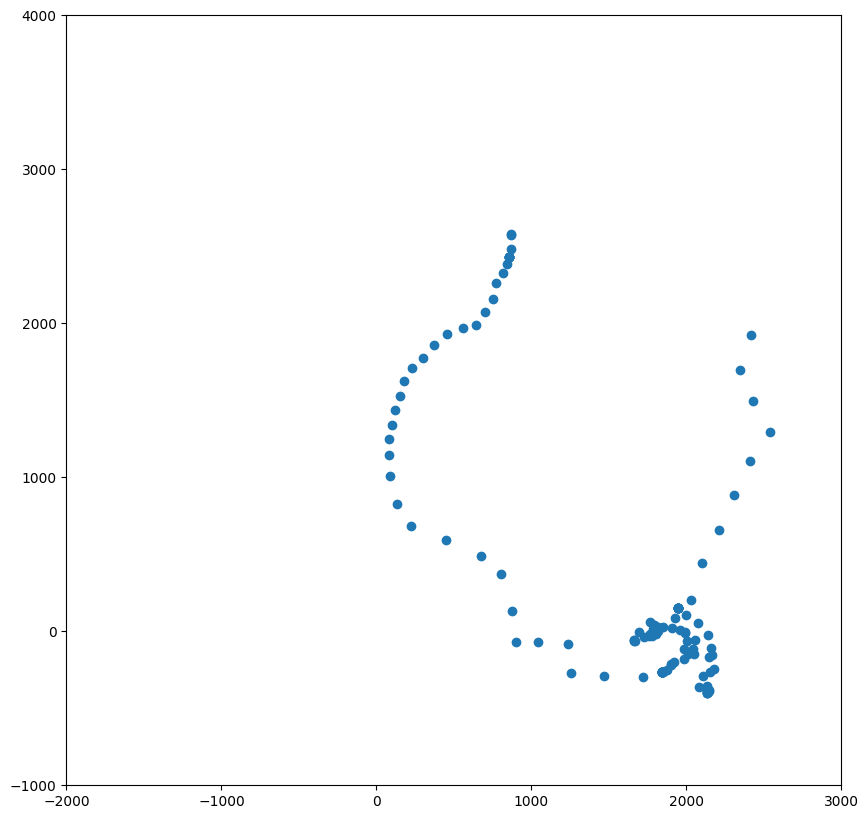

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(graph_data.loc[graph_data['roundNum'] == 11]['player4_x'], graph_data.loc[graph_data['roundNum'] == 11]['player4_y'])
plt.xlim(-2000, 3000)
plt.ylim(-1000, 4000)

### 2. Player name merge error fix

In [70]:
def get_names_stats_datasets():
    # Names dataset
    names = pd.read_csv('../../data/player-stats/names.csv')
    names['one'] = 1
    names['count'] = names.groupby(by='name')['one'].transform('sum')
    del names['one']

    # Stats dataset
    stats = pd.read_csv('../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv')
    return names.drop_duplicates(), stats

names, stats = get_names_stats_datasets()

In [127]:
mg = pd.merge(names, stats, left_on='name', right_on='player_name', how='left')
nans = mg.loc[mg["player_name"].isna()][['name','count']].reset_index(drop=True)
nans = nans.merge(pd.read_csv('../../data/player-stats/scraped-in-2024/2022/anonim_df.csv').iloc[0:len(nans)], left_index=True, right_index=True)
nans

,name,count,player_name,rating_1.0_data,weapon_data,rating_2.0,DPR,KAST,Impact,ADR,KPR,total_kills,HS%,total_deaths,KD_ratio,dmgPR,grenade_dmgPR,maps_played,rounds_played,APR,saved_by_teammatePR,saved_teammatesPR,rounds_with_kils,KD_diff,total_opening_kills,total_opening_deaths,opening_kill_ratio,opening_kill_rating,team_W%_after_opening,opening_kill_in_W_rounds,0_kill_rounds,1_kill_rounds,2_kill_rounds,3_kill_rounds,4_kill_rounds,5_kill_rounds,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills,maps_W%,rating_2.0_1+,rating_2.0_1+_streak,rating_1.0_all_Career,rating_1.0_online_Career,rating_1.0_lan_Career,rating_1.0_major_Career,clutches_won_1on1,clutches_lost_1on1,clutches_won_1on2,clutches_won_1on3,clutches_won_1on4,clutches_won_1on5
0,junior,2,anonim_pro,-,-,0.623202,0.651892,0.684481,0.579389,0.600231,0.595275,0.247784,0.447927,0.797234,0.384008,0.596328,0.136470,0.083588,0.230865,0.378501,0.518069,0.489801,0.252149,0.418432,0.212330,0.142753,0.320471,0.458643,0.738390,0.386235,0.224528,0.238546,0.244417,0.201330,0.185017,0.067104,0.188996,-0.010670,0.060985,0.263237,0.158350,0.026465,0.689946,0.514631,0.158117,0.310052,0.313561,0.390722,0.0,0.189001,0.206686,0.153401,0.067355,0.0,0.0
1,jeorge,2,anonim_pro,-,-,0.627633,0.668904,0.716676,0.599868,0.571400,0.601621,0.267503,0.411921,0.812592,0.386989,0.582949,0.106827,0.097859,0.261890,0.392803,0.475155,0.476698,0.277625,0.409135,0.169454,0.151425,0.304691,0.474379,0.709670,0.373092,0.245942,0.272861,0.228971,0.213984,0.169820,0.047488,0.158419,0.027725,0.078326,0.240752,0.188684,0.037064,0.683209,0.553182,0.166794,0.310091,0.293962,0.407385,0.0,0.204613,0.207380,0.135979,0.083486,0.0,0.0
2,headtr1ck,8,anonim_pro,-,-,0.661721,0.664633,0.723074,0.572091,0.567257,0.634776,0.220210,0.427630,0.799990,0.356281,0.596928,0.125775,0.084621,0.261495,0.374671,0.482174,0.507143,0.256318,0.378981,0.200439,0.129834,0.346951,0.483873,0.711392,0.386187,0.263970,0.270858,0.252761,0.206272,0.140872,0.081355,0.155405,0.007740,0.046987,0.252277,0.193570,0.064962,0.688843,0.543908,0.182597,0.311253,0.288718,0.393369,0.0,0.187565,0.167014,0.167617,0.093240,0.0,0.0
3,k1to,10,anonim_pro,-,-,0.640883,0.650404,0.706871,0.566378,0.594327,0.626390,0.240561,0.428005,0.777306,0.392511,0.569721,0.109504,0.104165,0.270201,0.396339,0.520189,0.514562,0.250702,0.407405,0.176461,0.168005,0.334908,0.497529,0.716371,0.386797,0.261290,0.253940,0.212301,0.188540,0.138821,0.071415,0.193344,-0.005675,0.057677,0.229411,0.195562,0.065643,0.663017,0.510245,0.165327,0.317833,0.307128,0.415194,0.0,0.204259,0.176207,0.131109,0.060399,0.0,0.0
4,prosus,2,anonim_pro,-,-,0.626864,0.662520,0.684010,0.571638,0.600599,0.622572,0.229495,0.410580,0.813511,0.390982,0.589795,0.143022,0.078466,0.277940,0.387530,0.487928,0.500974,0.252515,0.399999,0.183000,0.160743,0.349425,0.466807,0.733116,0.404361,0.262854,0.278770,0.226690,0.215761,0.162596,0.049092,0.162699,0.030112,0.068181,0.268687,0.185906,0.054396,0.654686,0.531429,0.200400,0.325680,0.332195,0.400031,0.0,0.204037,0.191247,0.169028,0.055507,0.0,0.0
5,JT,12,anonim_pro,-,-,0.669246,0.654430,0.701192,0.586988,0.571722,0.625646,0.257624,0.454030,0.783894,0.394090,0.597443,0.125129,0.088511,0.256383,0.355298,0.522067,0.510491,0.272012,0.380626,0.177407,0.160867,0.316357,0.467255,0.698264,0.403672,0.253507,0.243707,0.221979,0.190479,0.168577,0.077788,0.179818,0.018859,0.071763,0.263308,0.188543,0.055213,0.670917,0.556980,0.159897,0.344490,0.301155,0.411932,0.0,0.173303,0.169885,0.175003,0.078639,0.0,0.0
6,nafany,11,anonim_pro,-,-,0.627791,0.655746,0.715680,0.583554,0.594444,0.603134,0.230660,0.438570,0.815254,0.403142,0.564939,0.139659,0.078835,0.272458,0.390394,0.496234,0.489477,0.239111,0.378541,0.202373,0.150698,0.305313,0.498499,0.726602,0.402034,0.257515,0.261891,0.238370,0.222876,0.142095,0.055198,0.144639,-0.015452,0.064288,0.230863,0.178434,0.048583,0.652910,0.525008,0.186769,0.342413,0.325716,0.419622,0.0,0.194456,0.193700,0.178082,0.094184,0.0,0.0
7,

### 3. Other tests

In [52]:
import torch

pfd_pd = playerFrameData.drop(columns=['activeWeapon_M4A4']).copy()
pfd = torch.tensor(pfd_pd.astype('float32').values)
pfd = torch.cat((pfd[:, : -3], 69*torch.ones((10,1)), pfd[:, -3:]), dim=1)

In [53]:
pd.DataFrame(pfd.numpy(), columns=playerFrameData.columns)

,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,kills,deaths,sec,activeWeapon_AK-47,activeWeapon_AWP,activeWeapon_Desert Eagle,activeWeapon_Flashbang,activeWeapon_Galil AR,activeWeapon_Glock-18,activeWeapon_Knife,activeWeapon_M4A1,activeWeapon_M4A4,activeWeapon_Smoke Grenade,activeWeapon_USP-S,isCT
0,2492.222412,2071.601318,132.031250,2492.222412,2071.601318,196.093811,-76.375160,170.368362,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,1.0
1,2406.190186,2038.682129,128.031250,2406.190186,2038.682129,192.093811,-94.908333,-182.908722,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,1.0
2,2352.146484,1842.617920,128.031250,2352.146484,1842.617920,192.093811,-44.704262,-242.755402,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,1.0
3,2156.247559,1846.434814,171.846405,2156.247559,1846.434814,235.908966,-277.164856,-32.008446,-138.631622,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,1.0
4,2292.158936,1971.556152,128.031250,2292.158936,1971.556152,192.093811,-110.937187,-214.246552,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,1.0
5,-1524.365234,464.814362,-64.873459,-1524.365234,464.814362,-0.810898,92.401840,-232.297012,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,0.0
6,-1493.329956,273.753601,-61.961029,-1493.329956,273.753601,2.101532,206.466843,-128.398819,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,0.0
7,-1482.193848,349.312958,-64.742050,-1482.193848,349.312958,-0.679489,73.808731,-225.912552,0.000000,100.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1100.0,200.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,0.0
8,-1432.606445,240.619583,-60.628437,-1432.606445,240.619583,3.434124,244.682693,-51.286919,0.000000,100.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,850.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,0.0
9,-1516.122681,360.696625,-66.276566,-1516.122681,360.696625,-2.214005,13.836136,-190.604813,0.000000,100.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,800.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,0.0
